## Algoritmos Genéticos

### Punto 1

Módelo para el siguiente problema: Suponga que usted es el jefe de gobierno y está interesado en que pasen los proyectos de su programa político. Sin embargo, en el congreso conformado por 5 partidos, no es fácil su tránsito, por lo que debe repartir el poder, conformado por ministerios y otras agencias del gobierno, con base en la representación de cada partido. Cada entidad estatal tiene un peso de poder, que es el que se debe distribuir. Suponga que hay 50 curules, distribuya aleatoriamente, con una distribución no informe entre los 5 partidos esas curules. Defina una lista de 50 entidades y asígneles aleatoriamente un peso político de 1 a 100 puntos. Cree una matriz de poder para repartir ese poder, usando AGs.

In [ ]:
pip install deap

In [3]:
import random
import numpy as np

# Número de partidos y curules
n_partidos = 5
curules_totales = 50

# Distribuir curules entre los partidos (distribución no uniforme)
curules_por_partido = np.random.multinomial(curules_totales, [0.1, 0.2, 0.3, 0.25, 0.15])
print("Curules por partido:", curules_por_partido)

# Generar entidades con pesos políticos
entidades = [f"Entidad_{i}" for i in range(curules_totales)]
pesos_politicos = [random.randint(1, 100) for _ in entidades]

print("\nEntidades y sus pesos políticos:")
for entidad, peso in zip(entidades, pesos_politicos):
    print(f"{entidad}: {peso}")

from deap import base, creator, tools, algorithms

# Crear la clase Fitness y el individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar el error
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Definir la estructura del individuo
toolbox.register("attr_party", lambda: random.randint(0, n_partidos - 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_party, n=len(entidades))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluación: calcular el error de distribución de poder
def evaluar(individuo):
    # Sumar los pesos asignados a cada partido
    poder_partidos = [0] * n_partidos
    for entidad, partido in zip(entidades, individuo):
        poder_partidos[partido] += pesos_politicos[entidades.index(entidad)]
    
    # Error: diferencia absoluta entre poder y proporción de curules
    proporcion_esperada = [curules / curules_totales * sum(pesos_politicos) for curules in curules_por_partido]
    error = sum(abs(poder_partidos[i] - proporcion_esperada[i]) for i in range(n_partidos))
    return error,

toolbox.register("evaluate", evaluar)

# Operadores genéticos
toolbox.register("mate", tools.cxTwoPoint)  # Cruce de dos puntos
toolbox.register("mutate", tools.mutUniformInt, low=0, up=n_partidos - 1, indpb=0.2)  # Mutación
toolbox.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

# Configurar parámetros del algoritmo genético
pop = toolbox.population(n=100)
n_generaciones = 50

# Ejecutar el AG
resultados, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generaciones, verbose=True)


# Obtener el mejor individuo
mejor_individuo = tools.selBest(pop, k=1)[0]

# Mostrar la asignación final
poder_final = [0] * n_partidos
for entidad, partido in zip(entidades, mejor_individuo):
    poder_final[partido] += pesos_politicos[entidades.index(entidad)]

print("\nDistribución final del poder político por partido:")
for i in range(n_partidos):
    print(f"Partido {i + 1}: {poder_final[i]} puntos de poder")

print("\nCurules por partido (proporción esperada):", curules_por_partido)


Curules por partido: [ 3 10 15 14  8]

Entidades y sus pesos políticos:
Entidad_0: 81
Entidad_1: 15
Entidad_2: 78
Entidad_3: 77
Entidad_4: 67
Entidad_5: 35
Entidad_6: 16
Entidad_7: 73
Entidad_8: 86
Entidad_9: 76
Entidad_10: 70
Entidad_11: 86
Entidad_12: 24
Entidad_13: 49
Entidad_14: 34
Entidad_15: 5
Entidad_16: 13
Entidad_17: 8
Entidad_18: 59
Entidad_19: 61
Entidad_20: 20
Entidad_21: 39
Entidad_22: 19
Entidad_23: 5
Entidad_24: 54
Entidad_25: 53
Entidad_26: 13
Entidad_27: 74
Entidad_28: 29
Entidad_29: 21
Entidad_30: 76
Entidad_31: 38
Entidad_32: 27
Entidad_33: 92
Entidad_34: 95
Entidad_35: 38
Entidad_36: 100
Entidad_37: 94
Entidad_38: 11
Entidad_39: 99
Entidad_40: 53
Entidad_41: 91
Entidad_42: 69
Entidad_43: 89
Entidad_44: 99
Entidad_45: 77
Entidad_46: 74
Entidad_47: 90
Entidad_48: 52
Entidad_49: 73
gen	nevals
0  	100   
1  	74    
2  	87    
3  	80    
4  	80    
5  	74    
6  	80    
7  	70    
8  	78    
9  	73    
10 	83    
11 	68    
12 	75    
13 	56    
14 	75    
15 	62    
16 

## Punto 2:

In [5]:
import numpy as np
import random

# Parámetros del problema
capacities = [3, 6, 5, 4]  # Capacidad de cada planta
demands = [4, 3, 5, 3]     # Demanda de cada ciudad
transport_costs = np.array([
    [1, 4, 3, 6],
    [4, 1, 4, 5],
    [3, 4, 1, 4],
    [6, 5, 4, 1]
])
generation_costs = [680, 720, 660, 750]  # Costo por GW de cada planta

# Función de evaluación
def evaluate(individual):
    transport_cost = np.sum(transport_costs * individual)
    generation_cost = sum(generation_costs[i] * np.sum(individual[i, :]) for i in range(4))
    return transport_cost + generation_cost

# Validar y corregir una solución para que cumpla las restricciones
def validate_solution(individual):
    # Ajustar filas para no exceder la capacidad de las plantas
    for i in range(4):
        total_generated = np.sum(individual[i, :])
        if total_generated > capacities[i]:
            excess = total_generated - capacities[i]
            for j in range(4):
                if individual[i, j] > 0:
                    reduction = min(excess, individual[i, j])
                    individual[i, j] -= reduction
                    excess -= reduction
                    if excess <= 0:
                        break

    # Ajustar columnas para cumplir con la demanda de las ciudades
    for j in range(4):
        total_received = np.sum(individual[:, j])
        if total_received < demands[j]:
            deficit = demands[j] - total_received
            for i in range(4):
                available_capacity = capacities[i] - np.sum(individual[i, :])
                addition = min(deficit, available_capacity)
                individual[i, j] += addition
                deficit -= addition
                if deficit <= 0:
                    break
    return individual

# Generación inicial aleatoria respetando restricciones
def initialize_population(pop_size=50):
    population = []
    for _ in range(pop_size):
        individual = np.zeros((4, 4))
        for j in range(4):  # Distribuir la demanda de cada ciudad
            remaining_demand = demands[j]
            while remaining_demand > 0:
                i = random.randint(0, 3)  # Seleccionar una planta aleatoria
                available_capacity = capacities[i] - np.sum(individual[i, :])
                allocation = min(remaining_demand, available_capacity)
                individual[i, j] += allocation
                remaining_demand -= allocation
        population.append(validate_solution(individual))
    return population

# Selección de los mejores individuos
def select(population, fitness, num_parents=20):
    parents_indices = np.argsort(fitness)[:num_parents]
    return [population[i] for i in parents_indices]

# Crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, 3)
    child = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    return validate_solution(child)

# Mutación
def mutate(individual, mutation_rate=0.1):
    for _ in range(int(4 * 4 * mutation_rate)):  # Aproximadamente un 10% de las celdas
        i, j = random.randint(0, 3), random.randint(0, 3)
        adjustment = random.uniform(-1, 1)
        individual[i, j] = max(0, individual[i, j] + adjustment)
    return validate_solution(individual)

# Algoritmo genético principal
def genetic_algorithm(iterations=100, pop_size=50):
    population = initialize_population(pop_size)
    for generation in range(iterations):
        fitness = [evaluate(ind) for ind in population]
        parents = select(population, fitness)
        new_population = parents[:]
        while len(new_population) < pop_size:
            p1, p2 = random.sample(parents, 2)
            child = mutate(crossover(p1, p2))
            new_population.append(child)
        population = new_population
    # Devolver el mejor individuo
    best_idx = np.argmin([evaluate(ind) for ind in population])
    return population[best_idx], evaluate(population[best_idx])

# Ejecutar
best_solution, best_cost = genetic_algorithm()
print("Mejor solución encontrada:")
print(best_solution)
print("Costo total:", best_cost)



Mejor solución encontrada:
[[3. 0. 0. 0.]
 [1. 3. 0. 2.]
 [0. 0. 5. 0.]
 [0. 0. 0. 1.]]
Costo total: 10436.0


## Punto 3 y 4

Se decide para la solución de este ejercicio, para que tenga sentido, que se dejará la misma población inicial con sus respectivos fitness para realizar una comparación de los resultados entregados por la función cuando se modifican la estrategia de selección de progenitores, a saber, 3 estrategías: 
* Aptitud: La actual, la cual consistren en selección por proporción a su aptitud (fitness)
* Selección truncada: Selecciona un porcentaje fijo de los mejores individuos.
* Torneo: Selecciona los mejores entre un subconjunto aleatorio de la población

Para esto se graficará la evolución del resultado minimo de la población de cada estrategia. Adicional se verá el efecto del cambio en la solución frente a la variación de las generaciones con la estrategíoa propuesta por la solución.

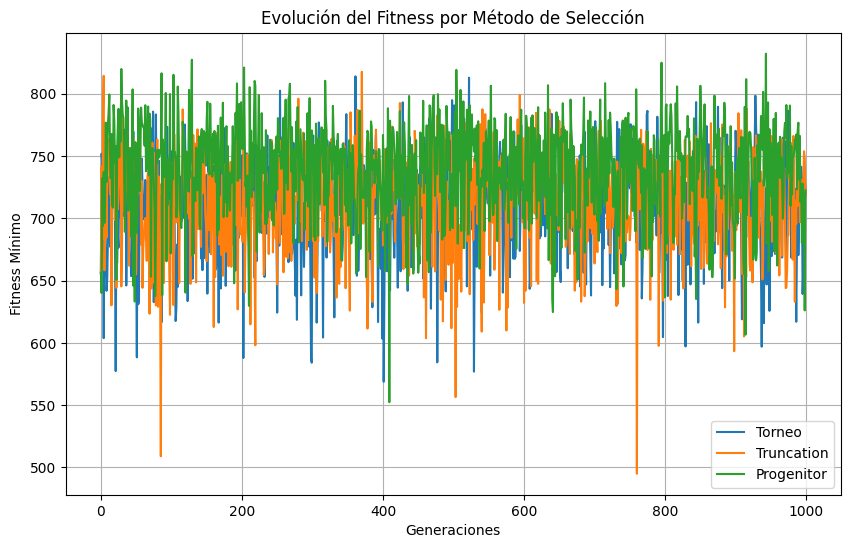

In [44]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import random

from datetime import datetime

# Parameters
n_cities = 20

n_population = 100

mutation_rate = 0.3

# Generating a list of coordenades representing each city
coordinates_list = [[x,y] for x,y in zip(np.random.randint(0,100,n_cities),np.random.randint(0,100,n_cities))]
names_list = np.array(['Berlin', 'London', 'Moscow', 'Barcelona', 'Rome', 'Paris', 'Vienna', 'Munich', 'Istanbul', 'Kyiv', 'Bucharest', 'Minsk', 'Warsaw', 'Budapest', 'Milan', 'Prague', 'Sofia', 'Birmingham', 'Brussels', 'Amsterdam'])
cities_dict = { x:y for x,y in zip(names_list,coordinates_list)}

# Function to compute the distance between two points
def compute_city_distance_coordinates(a,b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

def compute_city_distance_names(city_a, city_b, cities_dict):
    return compute_city_distance_coordinates(cities_dict[city_a], cities_dict[city_b])

cities_dict

# First step: Create the first population set
def genesis(city_list, n_population):

    population_set = []
    for i in range(n_population):
        #Randomly generating a new solution
        sol_i = city_list[np.random.choice(list(range(n_cities)), n_cities, replace=False)]
        population_set.append(sol_i)
    return np.array(population_set)

def fitness_eval(city_list, cities_dict):
    total = 0
    for i in range(n_cities-1):
        a = city_list[i]
        b = city_list[i+1]
        total += compute_city_distance_names(a,b, cities_dict)
    return total

def get_all_fitnes(population_set, cities_dict):
    fitnes_list = np.zeros(n_population)

    #Looping over all solutions computing the fitness for each solution
    for i in  range(n_population):
        fitnes_list[i] = fitness_eval(population_set[i], cities_dict)

    return fitnes_list

##ESTRATEGIA DE PROPUESTA POR EL AUTOR

def progenitor_selection(population_set, fitness_list):
    population_set = np.array(population_set)
    
    # Calcular probabilidades
    total_fit = fitness_list.sum()
    prob_list = fitness_list / total_fit
    
    # Seleccionar progenitores (índices)
    progenitor_list_a = np.random.choice(
        len(population_set), size=len(population_set), p=prob_list, replace=True
    )
    progenitor_list_b = np.random.choice(
        len(population_set), size=len(population_set), p=prob_list, replace=True
    )
    
    # Obtener progenitores seleccionados
    progenitor_list_a = population_set[progenitor_list_a]
    progenitor_list_b = population_set[progenitor_list_b]
    
    return np.array([progenitor_list_a, progenitor_list_b])


##ESTRATEGIA DE SELECCIÓN POR TORNEO

def tournament_selection(population_set, fitnes_list, k=3):
    progenitor_list_a = []
    progenitor_list_b = []
    
    for _ in range(len(population_set)):
        # Seleccionar k individuos aleatorios
        candidates_idx = np.random.choice(len(population_set), k, replace=False)
        # Seleccionar el de mejor fitness
        best_candidate_idx = candidates_idx[np.argmin(fitnes_list[candidates_idx])]
        progenitor_list_a.append(population_set[best_candidate_idx])

        # Repetir para la segunda lista
        candidates_idx = np.random.choice(len(population_set), k, replace=False)
        best_candidate_idx = candidates_idx[np.argmin(fitnes_list[candidates_idx])]
        progenitor_list_b.append(population_set[best_candidate_idx])
    
    return np.array([progenitor_list_a, progenitor_list_b])


##ESTRATEGIA DE SELECCIÓN POR TRUNCAMIENTO
def truncation_selection(population_set, fitness_list, truncation_rate=0.5):
    # Ordenar índices según el fitness (mejor a peor)
    ranked_idx = np.argsort(fitness_list)  # Índices ordenados por fitness ascendente (mejor primero)
    
    # Determinar el número de individuos seleccionados
    n_selected = max(1, int(truncation_rate * len(population_set)))
    selected_idx = ranked_idx[:n_selected]  # Seleccionar los mejores índices
    
    # Acceder a los individuos seleccionados
    selected_population = np.array(population_set)[selected_idx]
    
    # Crear listas de progenitores aleatorios seleccionados del truncamiento
    progenitor_list_a = selected_population[
        np.random.choice(len(selected_population), size=len(population_set), replace=True)
    ]
    progenitor_list_b = selected_population[
        np.random.choice(len(selected_population), size=len(population_set), replace=True)
    ]
    
    return np.array([progenitor_list_a, progenitor_list_b])






def mate_progenitors(prog_a, prog_b):
    offspring = prog_a[0:5]

    for city in prog_b:

        if not city in offspring:
            offspring = np.concatenate((offspring,[city]))

    return offspring
            
    
def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0][i], progenitor_list[1][i]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)
        
    return new_population_set


def mutate_offspring(offspring):
    for q in range(int(n_cities*mutation_rate)):
        a = np.random.randint(0,n_cities)
        b = np.random.randint(0,n_cities)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring
    
    
def mutate_population(new_population_set):
    mutated_pop = []
    for offspring in new_population_set:
        mutated_pop.append(mutate_offspring(offspring))
    return mutated_pop


##INICIALIZACIÓN DE POBLACIÓN PARA LA EVALUACIÓN

# Inicializar población
population_set = genesis(names_list, n_population)

# Evaluar el fitness inicial
fitness_list = get_all_fitnes(population_set, cities_dict)



##FUNCIÓN UTILIZADA PARA ALMACENAS LOS RESULTADOS DE LAS DIFERENTES ESTRATEGÍAS UTILIZADAS

def run_genetic_algorithm(selection_function, num_generations, population_set, fitness_list):
    # Variables globales del problema
    best_solution = [-1, np.inf, np.array([])]
    evolution = []

    for i in range(num_generations):
        # Almacenar evolución del mejor fitness
        evolution.append((i, fitness_list.min()))

        # Guardar la mejor solución encontrada
        if fitness_list.min() < best_solution[1]:
            best_solution[0] = i
            best_solution[1] = fitness_list.min()
            best_solution[2] = np.array(population_set)[fitness_list.min() == fitness_list]

        # Seleccionar progenitores con la función parametrizada
        progenitor_list = selection_function(population_set, fitness_list)

        # Cruce
        new_population_set = mate_population(progenitor_list)

        # Mutación
        population_set = mutate_population(new_population_set)

        # Reevaluar el fitness
        fitness_list = get_all_fitnes(population_set, cities_dict)

    return evolution, best_solution


# Ejemplo de ejecución con selección por truncamiento
evolution_truncation, best_solution_truncation = run_genetic_algorithm(truncation_selection, 1000,population_set, fitness_list)

# Ejemplo de ejecución con selección por torneo
evolution_tournament, best_solution_tournament = run_genetic_algorithm(tournament_selection, 1000,population_set, fitness_list)

# Ejemplo de ejecución con selección por ruleta
evolution_progenitor, best_solution_progenitor = run_genetic_algorithm(progenitor_selection, 1000,population_set, fitness_list)


# Función para graficar la evolución
def plot_evolution(evolutions, labels):
    plt.figure(figsize=(10, 6))
    
    for evolution, label in zip(evolutions, labels):
        generations, min_fitness = zip(*evolution)
        plt.plot(generations, min_fitness, label=label)
    
    plt.xlabel("Generaciones")
    plt.ylabel("Fitness Mínimo")
    plt.title("Evolución del Fitness por Método de Selección")
    plt.legend()
    plt.grid()
    plt.show()

# Graficar resultados
plot_evolution(
    [evolution_tournament, evolution_truncation, evolution_progenitor],
    ["Torneo", "Truncation", "Progenitor"]
)


Resultados según estrategía:

In [45]:
print("Torneo: " + str(best_solution_tournament))
print("Truncation: " + str(best_solution_truncation))
print("Progenitor: " + str(best_solution_progenitor))

Torneo: [401, 568.8351084133826, array([['Budapest', 'Munich', 'Vienna', 'Istanbul', 'Warsaw', 'Paris',
        'Sofia', 'Milan', 'Birmingham', 'Kyiv', 'Minsk', 'Amsterdam',
        'Berlin', 'Bucharest', 'Rome', 'Prague', 'Brussels', 'Moscow',
        'Barcelona', 'London']], dtype='<U10')]
Truncation: [760, 494.97822742244, array([['Warsaw', 'Barcelona', 'Moscow', 'London', 'Milan', 'Sofia',
        'Budapest', 'Kyiv', 'Berlin', 'Rome', 'Birmingham', 'Munich',
        'Vienna', 'Brussels', 'Paris', 'Istanbul', 'Bucharest', 'Prague',
        'Amsterdam', 'Minsk']], dtype='<U10')]
Progenitor: [409, 552.4111492704013, array([['Brussels', 'Warsaw', 'Paris', 'Milan', 'London', 'Sofia',
        'Moscow', 'Barcelona', 'Rome', 'Budapest', 'Birmingham',
        'Bucharest', 'Prague', 'Istanbul', 'Amsterdam', 'Minsk',
        'Vienna', 'Berlin', 'Kyiv', 'Munich']], dtype='<U10')]


Si aplicamos con diferentes poblaciones al metodo de torneo:

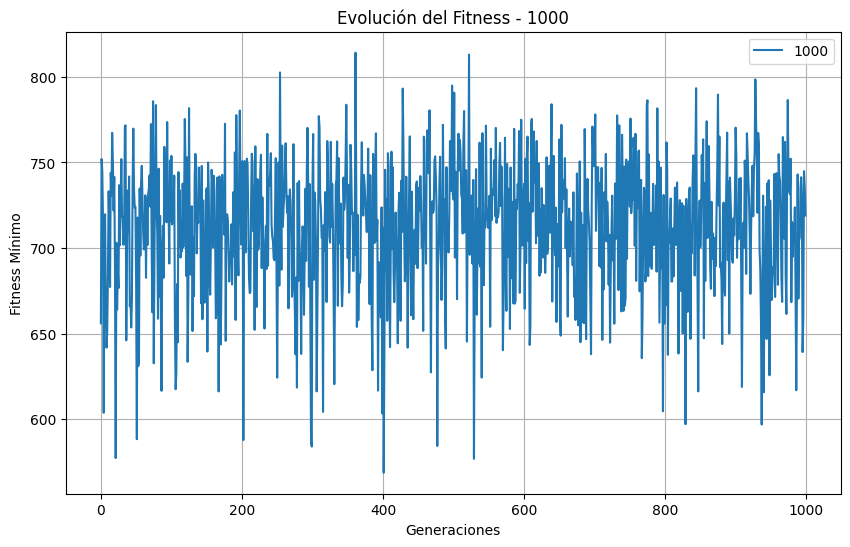

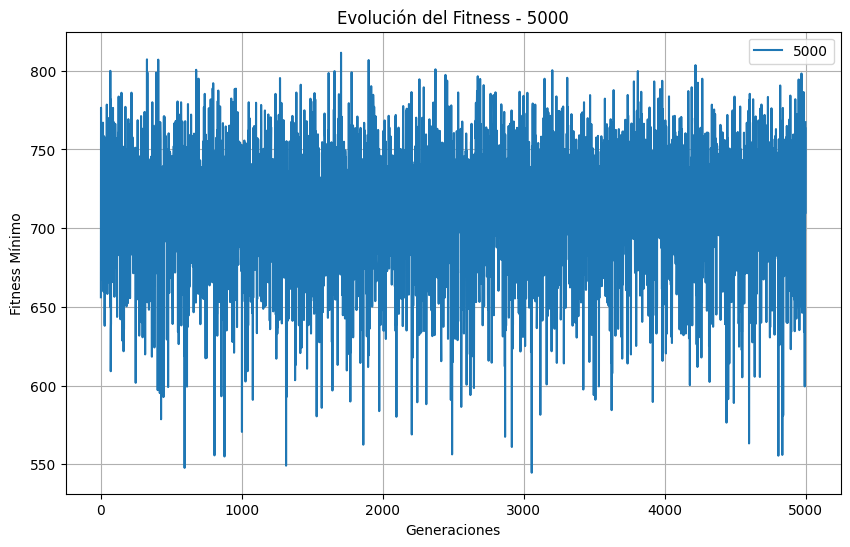

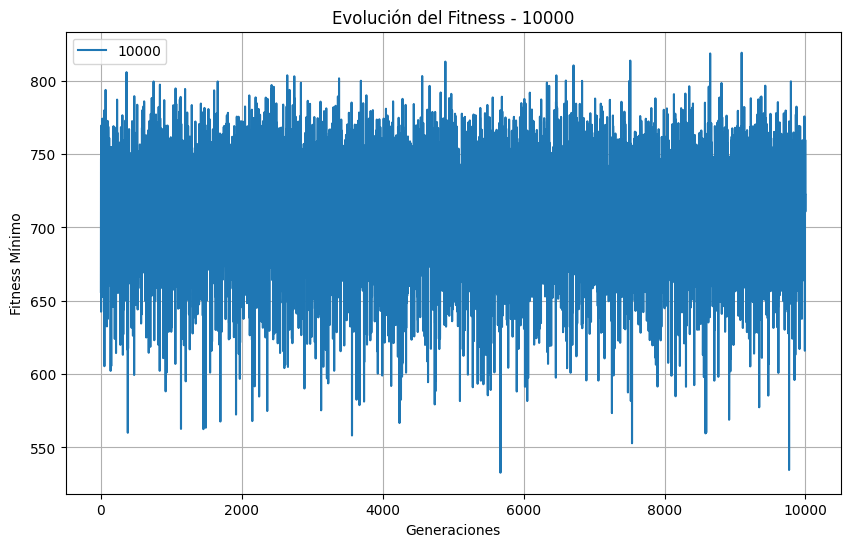

Torneo_1000: [401, 568.8351084133826, array([['Budapest', 'Munich', 'Vienna', 'Istanbul', 'Warsaw', 'Paris',
        'Sofia', 'Milan', 'Birmingham', 'Kyiv', 'Minsk', 'Amsterdam',
        'Berlin', 'Bucharest', 'Rome', 'Prague', 'Brussels', 'Moscow',
        'Barcelona', 'London']], dtype='<U10')]
Torneo_5000: [3057, 544.6525805080926, array([['Barcelona', 'Bucharest', 'Rome', 'Vienna', 'Munich', 'Kyiv',
        'Budapest', 'Birmingham', 'Prague', 'Berlin', 'Warsaw', 'Paris',
        'Moscow', 'Brussels', 'Sofia', 'Milan', 'London', 'Istanbul',
        'Minsk', 'Amsterdam']], dtype='<U10')]
Torneo_10000: [5671, 532.7404928731828, array([['Kyiv', 'Rome', 'Istanbul', 'Amsterdam', 'Minsk', 'Prague',
        'Barcelona', 'Moscow', 'Vienna', 'Berlin', 'Budapest',
        'Birmingham', 'Munich', 'Bucharest', 'Brussels', 'Paris',
        'Warsaw', 'Sofia', 'Milan', 'London']], dtype='<U10')]


In [46]:
#selección por torneo con 1000 iteraciones
evolution_tournament_1000 = evolution_tournament

#selección por torneo con 5000 iteraciones
evolution_tournament_5000, best_solution_tournament_5000 = run_genetic_algorithm(tournament_selection, 5000,population_set, fitness_list)

#selección por torneo con 10000 iteraciones
evolution_tournament_10000, best_solution_tournament_10000 = run_genetic_algorithm(tournament_selection, 10000,population_set, fitness_list)

# Función para graficar la evolución en figuras independientes
def plot_evolution_ind(evolutions, labels):
    for evolution, label in zip(evolutions, labels):
        plt.figure(figsize=(10, 6))  # Crear una nueva figura para cada gráfico
        
        generations, min_fitness = zip(*evolution)
        plt.plot(generations, min_fitness, label=label)
        
        plt.xlabel("Generaciones")
        plt.ylabel("Fitness Mínimo")
        plt.title(f"Evolución del Fitness - {label}")
        plt.legend()
        plt.grid()
        plt.show()  # Mostrar el gráfico para cada evolución



# Graficar resultados
plot_evolution_ind(
    [evolution_tournament_1000, evolution_tournament_5000, evolution_tournament_10000],
    ["1000", "5000", "10000"]
)


print("Torneo_1000: " + str(best_solution_tournament))
print("Torneo_5000: " + str(best_solution_tournament_5000))
print("Torneo_10000: " + str(best_solution_tournament_10000))

## PUNTO 5

Para este punto se van a seleccionar 50 palabras de la misma longitud para minimizar la complejidad de encontrar la palabra elegida, la cual será zorro

In [23]:
# Lista de palabras de longitud 5 sin tildes
palabras = [
    "perro", "gatos", "luzas", "ratas", "piano", "mango", "vacas", "lucha", "lente", "mesas",
    "noche", "cinta", "pipas", "flore", "lomos", "tazas", "silla", "salta", "paseo", "banco",
    "sanco", "bello", "pinta", "campa", "lento", "chico", "firme", "nubes", "grano", "sumas",
    "almas", "banco", "tacho", "fresa", "tarta", "lomos", "viento", "baila", "lomos", "porro",
    "llama", "rojos", "pausa", "vigas", "vices", "finca", "canto", "manto", "pacto", "lados"
]

In [24]:
# Parámetros del AG
TARGET_WORD = "zorro"  # Palabra objetivo
POPULATION_SIZE = 50  # Tamaño de la población
MUTATION_RATE = 0.1   # Probabilidad de mutación por carácter
GENES = "abcdefghijklmnopqrstuvwxyz "  # Caracteres permitidos
MAX_GENERATIONS = 1000  # Límite de generaciones para evitar bucles infinitos

#Calcula la aptitud comparando con la palabra objetivo.
def calculate_fitness(word):
    return sum(1 for w, t in zip(word, TARGET_WORD) if w == t)

#Aplica una mutación a una palabra.
def mutate(word):
    word_list = list(word)
    for i in range(len(word_list)):
        if random.random() < MUTATION_RATE:
            word_list[i] = random.choice(GENES)
    return ''.join(word_list)

#Realiza un cruce entre dos palabras.
def crossover(parent1, parent2):
    split_point = random.randint(1, len(parent1) - 1)
    return parent1[:split_point] + parent2[split_point:]

#Selecciona dos padres utilizando selección proporcional a la aptitud.
def select_parents(population, fitnesses):
    total_fitness = sum(fitnesses)
    if total_fitness == 0:  # Evitar división por cero
        return random.choices(population, k=2)
    probabilities = [f / total_fitness for f in fitnesses]
    return random.choices(population, weights=probabilities, k=2)

# Algoritmo Genético principal
def genetic_algorithm():
    population = palabras
    for generation in range(MAX_GENERATIONS):
        # Calcular aptitudes
        fitnesses = [calculate_fitness(word) for word in population]
        
        # Verificar si se encontró la solución
        if TARGET_WORD in population:
            print(f"¡Palabra encontrada! '{TARGET_WORD}' en la generación {generation}")
            return
        
        # Crear nueva población
        new_population = []
        for _ in range(POPULATION_SIZE // 2):  # Crear pares de hijos
            parent1, parent2 = select_parents(population, fitnesses)
            child1 = mutate(crossover(parent1, parent2))
            child2 = mutate(crossover(parent2, parent1))
            new_population.extend([child1, child2])
        
        population = new_population  # Reemplazar con la nueva población

    print("No se encontró la palabra objetivo en el límite de generaciones.")

# Ejecución
genetic_algorithm()


¡Palabra encontrada! 'zorro' en la generación 25


## PUNTO 6

Se selecciona el problema del viajero para solucionar con Pygad, con los datos que se usaron para las ejecuciones anteriores:


In [27]:
pip install pygad

     -------------------------------------- 84.1/84.1 kB 678.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Debido a que pygad no va a procesar los nombres de las ciudades como string, se realiza la siguiente conversion de nombre de ciudad a indices numéricos. Adicional, como no hay forma de confirmar que no se repitan ciudades de manera directa se modifica la función que calcula el fitness a una que, incialmente, pueda usar pygen y que penalice si hay ciudades repetidas, esto se hace através del uso del inverso, ya que por defecto las funciones en pygen se buscan que se maximicen, y devolviendo 0 en caso de tener ciudades repetidas

In [56]:
# Crear un diccionario que asocia los nombres de las ciudades con índices numéricos
city_name_to_index = {name: idx+1 for idx, name in enumerate(names_list)}

# Función para convertir una solución de nombres de ciudades a índices
def convert_solution_to_indices(solution, city_name_to_index):
    return [city_name_to_index[city] for city in solution]

# Convertir cada solución de la población a índices
population_set_index = np.array([convert_solution_to_indices(solution, city_name_to_index) for solution in population_set])

index_to_city_name = {v: k for k, v in city_name_to_index.items()}

# Verifica que la población ahora tiene índices en lugar de nombres
print(index_to_city_name)

{1: 'Berlin', 2: 'London', 3: 'Moscow', 4: 'Barcelona', 5: 'Rome', 6: 'Paris', 7: 'Vienna', 8: 'Munich', 9: 'Istanbul', 10: 'Kyiv', 11: 'Bucharest', 12: 'Minsk', 13: 'Warsaw', 14: 'Budapest', 15: 'Milan', 16: 'Prague', 17: 'Sofia', 18: 'Birmingham', 19: 'Brussels', 20: 'Amsterdam'}


In [64]:
import pygad

# Función de fitness (calcular la distancia, como en el código anterior)
def fitness_function(ga_instance, solution, solution_idx):
    total_distance = 0

    # Convertir la solución en nombres de ciudades
    cities_order = [index_to_city_name[idx] for idx in solution]
    
    # Verificar si hay ciudades repetidas
    if len(set(cities_order)) != len(cities_order):
        return 0  # Penalización si hay ciudades repetidas
    
    # Calcular la distancia total para el recorrido
    for i in range(len(cities_order) - 1):
        a = cities_order[i]
        b = cities_order[i + 1]
        total_distance += compute_city_distance_names(a, b, cities_dict)
    
    # Minimizar: devolver el inverso de la distancia (a maximizar)
    return 1 / total_distance if total_distance > 0 else 0



# Inicializar el objeto GA de Pygad
ga_instance = pygad.GA(
    num_generations=1000,  # Igual que en la ejecución del código anterior
    num_parents_mating=10,  # Número de progenitores para el cruce
    fitness_func=fitness_function,  # Usamos la misma función de fitness
    sol_per_pop=n_population,  # Número de soluciones por población
    num_genes=len(cities_dict),  # El número de genes es igual al número de ciudades
    initial_population=population_set_index,  # Usamos la población inicial generada
    mutation_percent_genes=30,  # Tasa de mutación
    crossover_type="uniform",  # Tipo de cruce (uniforme)
    crossover_probability=1,  # Probabilidad de cruce
    mutation_type="swap",  # Tipo de mutación (swap de dos ciudades)
    mutation_probability=0.2,  # Probabilidad de mutación
    parent_selection_type="tournament",  # Selección por torneo
    K_tournament=3,  # Tamaño del torneo (k=3, como en el código original)
    keep_parents=2,  # Mantener los mejores padres
)

# Ejecutar el algoritmo genético
ga_instance.run()

def convert_indices_to_names(index_list, city_name_to_index):
    # Crear el diccionario inverso: mapa de índices a nombres de ciudades
    index_to_city_name = {idx: name for name, idx in city_name_to_index.items()}
    
    # Convertir la lista de índices a nombres de ciudades
    name_list = [index_to_city_name[idx] for idx in index_list]
    
    return name_list

# Obtener la mejor solución
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print("Mejor solución (ruta del viajero):", convert_indices_to_names(best_solution,city_name_to_index))
print("Distancia total:", best_solution_fitness)

Mejor solución (ruta del viajero): ['Paris', 'Warsaw', 'Rome', 'Vienna', 'Birmingham', 'Budapest', 'Munich', 'Kyiv', 'Amsterdam', 'Minsk', 'Moscow', 'Prague', 'Berlin', 'Bucharest', 'Brussels', 'Barcelona', 'London', 'Milan', 'Sofia', 'Istanbul']
Distancia total: 0.0016243954419265234


In [65]:
print(fitness_eval(convert_indices_to_names(best_solution,city_name_to_index),cities_dict))

615.6136456613089
